In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, LassoCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                              HistGradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier,
                              StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import time
import warnings
import scipy.stats

warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# Step 1: Data loading and preprocessing
# =============================================================================
print("\n" + "=" * 120)
print("STEP 1: DATA LOADING AND PREPROCESSING")
print("=" * 120)

# Load dataset
data = pd.read_excel("Supplementary data 1.xlsx")
X = data.drop(columns=["TYPE", "SUBJECT_ID"])
y = data["TYPE"]

print(f"Dataset: {data.shape[0]} samples, {X.shape[1]} features")
print(f"Class distribution: Benign: {(y == 0).sum()}, Malignant: {(y == 1).sum()}")


STEP 1: DATA LOADING AND PREPROCESSING
Dataset: 349 samples, 49 features
Class distribution: Benign: 171, Malignant: 178


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SUBJECT_ID  349 non-null    int64  
 1   AFP         327 non-null    object 
 2   AG          348 non-null    float64
 3   Age         349 non-null    int64  
 4   ALB         339 non-null    float64
 5   ALP         339 non-null    float64
 6   ALT         339 non-null    float64
 7   AST         339 non-null    float64
 8   BASO#       349 non-null    float64
 9   BASO%       349 non-null    float64
 10  BUN         349 non-null    float64
 11  Ca          349 non-null    float64
 12  CA125       332 non-null    object 
 13  CA19-9      325 non-null    object 
 14  CA72-4      109 non-null    float64
 15  CEA         327 non-null    float64
 16  CL          349 non-null    float64
 17  CO2CP       348 non-null    float64
 18  CREA        349 non-null    float64
 19  TYPE        349 non-null    i

In [3]:
# Check for missing values
has_missing = data.isnull().any().any()
print(f"Dataset contains missing values: {has_missing}")

# Summarize missing values per feature
missing_summary = data.isnull().sum()
print("\nMissing values per feature:")
print(missing_summary[missing_summary > 0])  # Show only features with missing values

Dataset contains missing values: True

Missing values per feature:
AFP        22
AG          1
ALB        10
ALP        10
ALT        10
AST        10
CA125      17
CA19-9     24
CA72-4    240
CEA        22
CO2CP       1
DBIL       10
GGT        10
GLO        10
HE4        20
IBIL       10
MPV         2
NEU        91
PCT         2
PDW         2
TBIL       10
TP         10
dtype: int64


In [5]:
# Convert object columns with non-numeric entries to numeric (coerce errors to NaN)
def clean_numeric(series: pd.Series) -> pd.Series:
    if series.dtype == "object":
        return pd.to_numeric(
            series.astype(str).str.replace(r"[^\d\.\-eE]", "", regex=True).str.strip(),
            errors="coerce",
        )
    return series

X = X.apply(clean_numeric)

# Remove CA72-4 (not measured in the cohort)
if "CA72-4" in X.columns:
    X = X.drop(columns=["CA72-4"])

# Impute missing NEU values using the complement of other leukocyte percentages
pct_complements = ["LYM%", "MONO%", "EO%", "BASO%"]
if all(col in X.columns for col in pct_complements):
    neu_derived = 100 - X[pct_complements].sum(axis=1)
    mask = X["NEU"].isna() & neu_derived.between(0, 100)
    X.loc[mask, "NEU"] = neu_derived[mask]

# Create missing-indicator variables for key tumor markers and neutrophil count
for col in ["AFP", "CA125", "CA19-9", "CEA", "HE4", "NEU"]:
    if col in X.columns:
        X[f"{col}_missing"] = X[col].isna().astype(int)

print(f"Total features after preprocessing: {X.shape[1]}")

# Display all feature names (sorted alphabetically for readability)
feature_names = sorted(X.columns.tolist())
print("\nFinal feature set after preprocessing (n = {}):".format(X.shape[1]))
for i, name in enumerate(feature_names, 1):
    print(f"{i:3d}. {name}")

Total features after preprocessing: 54

Final feature set after preprocessing (n = 54):
  1. AFP
  2. AFP_missing
  3. AG
  4. ALB
  5. ALP
  6. ALT
  7. AST
  8. Age
  9. BASO#
 10. BASO%
 11. BUN
 12. CA125
 13. CA125_missing
 14. CA19-9
 15. CA19-9_missing
 16. CEA
 17. CEA_missing
 18. CL
 19. CO2CP
 20. CREA
 21. Ca
 22. DBIL
 23. EO#
 24. EO%
 25. GGT
 26. GLO
 27. GLU.
 28. HCT
 29. HE4
 30. HE4_missing
 31. HGB
 32. IBIL
 33. K
 34. LYM#
 35. LYM%
 36. MCH
 37. MCV
 38. MONO#
 39. MONO%
 40. MPV
 41. Menopause
 42. Mg
 43. NEU
 44. NEU_missing
 45. Na
 46. PCT
 47. PDW
 48. PHOS
 49. PLT
 50. RBC
 51. RDW
 52. TBIL
 53. TP
 54. UA


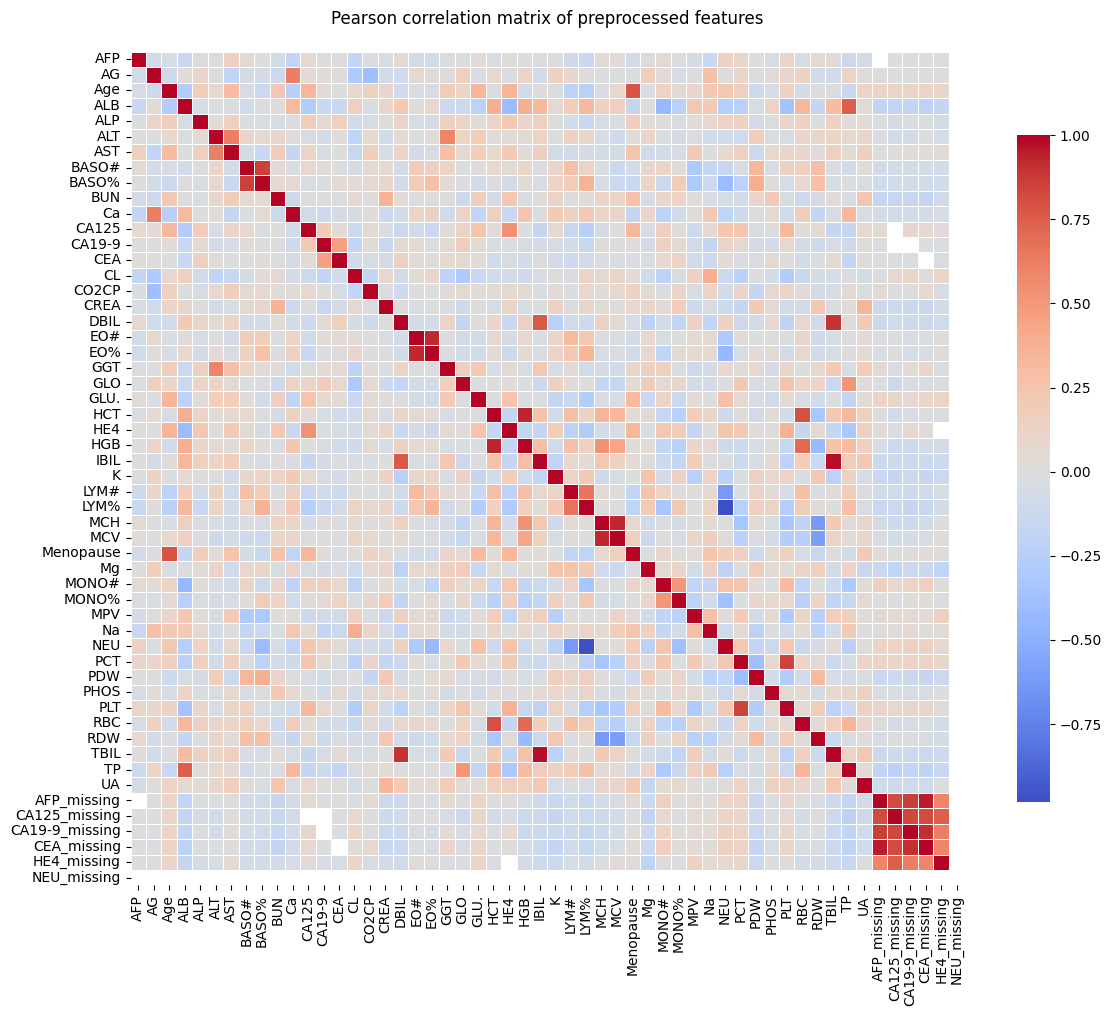

In [6]:
# Compute Pearson correlation matrix
corr_matrix = X.corr(method="pearson")

# Generate and display correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0.0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    xticklabels=True,
    yticklabels=True,
)
plt.title("Pearson correlation matrix of preprocessed features", pad=20)
plt.tight_layout()
plt.show()

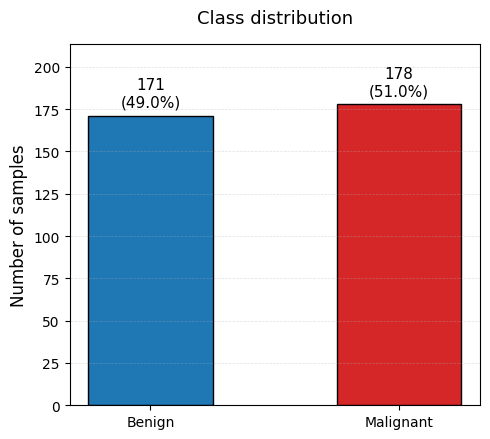

In [16]:

# Class distribution

class_labels = ["Benign", "Malignant"]
counts = [(y == 0).sum(), (y == 1).sum()]

fig, ax = plt.subplots(figsize=(5, 4.5))

bars = ax.bar(
    class_labels,
    counts,
    color=["#1f77b4", "#d62728"],
    edgecolor="black",
    linewidth=1,
    width=0.5,
)

ax.set_ylabel("Number of samples", fontsize=12)
ax.set_ylim(0, max(counts) * 1.20)
ax.grid(axis="y", linestyle="--", alpha=0.4, linewidth=0.5)

# Add count and percentage on top of each bar
for i, count in enumerate(counts):
    pct = 100 * count / len(y)
    ax.text(
        i,
        count + max(counts) * 0.02,
        f"{count}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=11,
    )

ax.set_title("Class distribution", pad=15, fontsize=13, fontweight="medium")
ax.tick_params(axis="both", which="major", labelsize=10)

plt.tight_layout()
plt.show()

In [17]:
# =============================================================================
# STEP 2: TRAIN-TEST SPLIT
# =============================================================================
print("\n" + "="*120)
print("STEP 2: STRATIFIED TRAIN-TEST SPLIT")
print("="*120)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")


STEP 2: STRATIFIED TRAIN-TEST SPLIT
Training: 279 samples, Test: 70 samples


In [18]:
# =============================================================================
# Step 3: Feature preprocessing (log-transformation, imputation, standardization)
# =============================================================================
print("\n" + "=" * 120)
print("STEP 3: FEATURE PREPROCESSING")
print("=" * 120)

# Tumor markers (highly right-skewed) – apply log1p transformation
tumor_markers = [col for col in ["AFP", "CA125", "CA19-9", "CEA", "HE4"] if col in X_train.columns]

for col in tumor_markers:
    X_train[col] = np.log1p(X_train[col])
    X_test[col]  = np.log1p(X_test[col])

# Impute missing values in tumor markers using k-NN (distance-weighted)
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
X_train[tumor_markers] = knn_imputer.fit_transform(X_train[tumor_markers])
X_test[tumor_markers]  = knn_imputer.transform(X_test[tumor_markers])

# Remaining continuous clinical/laboratory features – median imputation
clinical_features = [
    col for col in X_train.columns
    if col not in tumor_markers
    and not col.endswith("_missing")
    and X_train[col].dtype in ["float64", "int64"]
]

median_imputer = SimpleImputer(strategy="median")
X_train[clinical_features] = median_imputer.fit_transform(X_train[clinical_features])
X_test[clinical_features]  = median_imputer.transform(X_test[clinical_features])

# Standardize all features to zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Preprocessing complete (log₁₊ transformation → k-NN/median imputation → z-score standardization)")


STEP 3: FEATURE PREPROCESSING
Preprocessing complete (log₁₊ transformation → k-NN/median imputation → z-score standardization)


In [23]:
# =============================================================================
# STEP 4: CONSENSUS FEATURE SELECTOR 
# =============================================================================
print("\n" + "="*120)
print("STEP 4: DEFINING CONSENSUS FEATURE SELECTOR")
print("="*120)

class ConsensusFeatureSelector(BaseEstimator, TransformerMixin):
    """Consensus-based feature selection using LASSO, RF, F-stat, and LR."""
    def __init__(self, n_methods_threshold=2, k_features=25):
        self.n_methods_threshold = n_methods_threshold
        self.k_features = k_features
        self.selected_indices_ = None

    def fit(self, X, y):
        X_arr, y_arr = np.array(X), np.array(y)
        n_features = X_arr.shape[1]
        votes = np.zeros(n_features)

        # Vote from 4 methods
        for selector_class, kwargs in [
            (SelectFromModel, {'estimator': LassoCV(cv=3, random_state=42), 'max_features': self.k_features}),
            (SelectFromModel, {'estimator': RandomForestClassifier(n_estimators=50, random_state=42), 'max_features': self.k_features}),
            (SelectKBest, {'score_func': f_classif, 'k': self.k_features}),
            (SelectFromModel, {'estimator': LogisticRegression(max_iter=500, random_state=42), 'max_features': self.k_features})
        ]:
            try:
                selector = selector_class(**kwargs)
                selector.fit(X_arr, y_arr)
                votes[selector.get_support()] += 1
            except:
                pass

        self.selected_indices_ = np.where(votes >= self.n_methods_threshold)[0]

        # Fallback to F-stat if no features meet threshold
        if len(self.selected_indices_) == 0:
            f_stat = SelectKBest(f_classif, k=self.k_features)
            f_stat.fit(X_arr, y_arr)
            self.selected_indices_ = f_stat.get_support(indices=True)

        return self

    def transform(self, X):
        return np.array(X)[:, self.selected_indices_]

print("ConsensusFeatureSelector defined")


STEP 4: DEFINING CONSENSUS FEATURE SELECTOR
ConsensusFeatureSelector defined



STEP 5: SELECTED FEATURES AND CORRELATION ANALYSIS

Number of selected features: 26
Selected features (consensus ≥ 2 methods):
--------------------------------------------------
 1. AFP
 2. Age
 3. ALB
 4. ALP
 5. AST
 6. Ca
 7. CA125
 8. CEA
 9. CL
10. EO%
11. GLO
12. HE4
13. IBIL
14. LYM%
15. MCH
16. MCV
17. Menopause
18. MPV
19. NEU
20. PLT
21. TBIL
22. AFP_missing
23. CA125_missing
24. CA19-9_missing
25. CEA_missing
26. HE4_missing


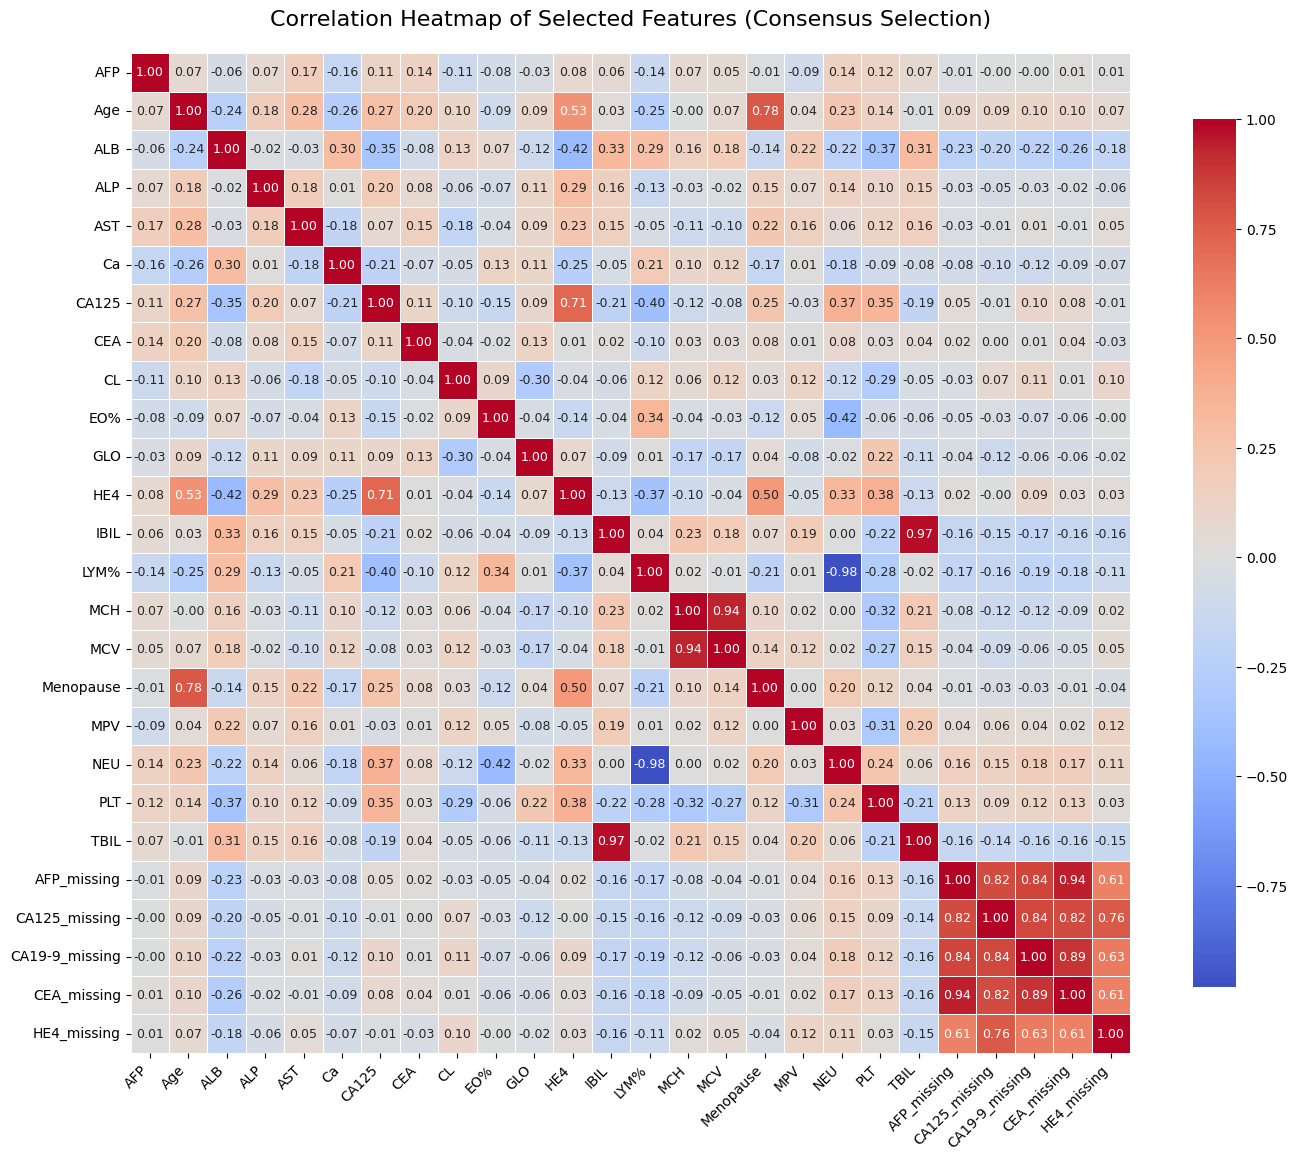


Highly correlated feature pairs (|r| > 0.7):
  LYM%                           ↔ NEU                            : -0.980
  IBIL                           ↔ TBIL                           :  0.974
  AFP_missing                    ↔ CEA_missing                    :  0.944
  MCH                            ↔ MCV                            :  0.937
  CA19-9_missing                 ↔ CEA_missing                    :  0.894
  AFP_missing                    ↔ CA19-9_missing                 :  0.840
  CA125_missing                  ↔ CA19-9_missing                 :  0.835
  CA125_missing                  ↔ CEA_missing                    :  0.819
  AFP_missing                    ↔ CA125_missing                  :  0.819
  Age                            ↔ Menopause                      :  0.775
  CA125_missing                  ↔ HE4_missing                    :  0.761
  CA125                          ↔ HE4                            :  0.715


In [24]:
# =============================================================================
# STEP 5: DISPLAY SELECTED FEATURES & CORRELATION HEATMAP
# =============================================================================
print("\n" + "="*120)
print("STEP 5: SELECTED FEATURES AND CORRELATION ANALYSIS")
print("="*120)

# Fit the consensus selector (assuming X_train and y_train are your data)
consensus_selector = ConsensusFeatureSelector(n_methods_threshold=2, k_features=25)
consensus_selector.fit(X_train, y_train)

# Get selected feature indices and names
selected_indices = consensus_selector.selected_indices_
selected_feature_names = X_train.columns[selected_indices] if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in selected_indices]

print(f"\nNumber of selected features: {len(selected_feature_names)}")
print("Selected features (consensus ≥ {0} methods):".format(consensus_selector.n_methods_threshold))
print("-" * 50)
for i, feat_name in enumerate(selected_feature_names):
    print(f"{i+1:2d}. {feat_name}")

# Transform the training data to selected features only
X_train_selected = consensus_selector.transform(X_train)
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)

# Compute correlation matrix
corr_matrix = X_train_selected_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    xticklabels=selected_feature_names,
    yticklabels=selected_feature_names,
    annot_kws={'size': 9}
)
plt.title('Correlation Heatmap of Selected Features (Consensus Selection)', 
          fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Highlight highly correlated pairs (>0.7 or <-0.7)
print("\n" + "Highly correlated feature pairs (|r| > 0.7):".format())
high_corr = (corr_matrix.abs() > 0.7) & (corr_matrix != 1.0)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if high_corr.iloc[i, j]:
            corr_val = corr_matrix.iloc[i, j]
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if high_corr_pairs:
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1:30s} ↔ {feat2:30s} : {corr:6.3f}")
else:
    print("  No feature pairs with |correlation| > 0.7")

In [25]:
# =============================================================================
# STEP 5: DEFINE 10 MODELS WITH PIPELINES
# =============================================================================
print("\n" + "="*120)
print("STEP 5: DEFINING 10 MODELS WITH INTEGRATED CONSENSUS SELECTION")
print("="*120)

def create_pipeline(classifier, k_features=25):
    """Factory function for creating model pipelines."""
    return Pipeline([('selector', ConsensusFeatureSelector(k_features=k_features)), ('clf', classifier)])

models_with_grids = {
    '01. Logistic Regression': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {
            'selector__k_features': [20, 30],
            'clf__C': [1, 10]
        }
    },
    '02. Ridge Classifier': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', RidgeClassifier(random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__alpha': [0.1, 1.0]}
    },
    '03. SGD Classifier': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', SGDClassifier(random_state=42, class_weight='balanced', max_iter=2000))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__alpha': [0.001]}
    },
    '04. SVM (RBF Kernel)': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__C': [10, 100]}
    },
    '05. SVM (Linear Kernel)': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__C': [1, 10]}
    },
    '06. K-Nearest Neighbors': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', KNeighborsClassifier())
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__n_neighbors': [7], 'clf__weights': ['distance']}
    },
    '07. Linear Discriminant Analysis': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', LinearDiscriminantAnalysis())
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__solver': ['lsqr']}
    },
    '08. Quadratic Discriminant Analysis': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', QuadraticDiscriminantAnalysis())
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__reg_param': [0.1]}
    },
    '09. Random Forest': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__n_estimators': [300]}
    },
        '10. Extra Trees': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', ExtraTreesClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__n_estimators': [300]}
    },
    '11. Multi-layer Perceptron': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', MLPClassifier(max_iter=1000, random_state=42, early_stopping=True))
        ]),
        'param_grid': {'selector__k_features': [30], 'clf__hidden_layer_sizes': [(64, 32)]}
    }
}

print(f"✓ Defined {len(models_with_grids)} models")


STEP 5: DEFINING 10 MODELS WITH INTEGRATED CONSENSUS SELECTION
✓ Defined 11 models


In [26]:
# =============================================================================
# Helper functions: Performance evaluation and confidence intervals
# =============================================================================

def wilson_score_interval(n_success: int, n_total: int, confidence: float = 0.95):
    """Wilson score interval for binomial proportion (95% CI by default)."""
    if n_total == 0:
        return (0.0, 0.0)
    z = scipy.stats.norm.ppf(1 - (1 - confidence) / 2)
    p = n_success / n_total
    denominator = 1 + z**2 / n_total
    center = (p + z**2 / (2 * n_total)) / denominator
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * n_total)) / n_total) / denominator
    return (center - margin, center + margin)


def evaluate_cv_comprehensive(estimator, X, y, cv, name: str):
    """
    Comprehensive repeated cross-validation evaluation.
    Returns a dictionary of mean performance metrics across folds.
    """
    start = time.time()
    
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "auc": "roc_auc",
    }
    
    cv_results = cross_validate(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    
    y_pred = cross_val_predict(estimator, X, y, cv=cv, n_jobs=-1)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    duration = time.time() - start
    acc_mean = cv_results["test_accuracy"].mean()
    rec_mean = cv_results["test_recall"].mean()
    
    return {
        "Model": name,
        "Accuracy": acc_mean,
        "Precision": cv_results["test_precision"].mean(),
        "Recall": rec_mean,
        "F1-Score": cv_results["test_f1"].mean(),
        "ROC-AUC": cv_results["test_auc"].mean(),
        "Error_Rate": 1 - acc_mean,
        "Execution_Time_s": duration,
        "TPR": rec_mean,
        "FPR": fp / (fp + tn) if (fp + tn) > 0 else 0.0,
        "FNR": fn / (fn + tp) if (fn + tp) > 0 else 0.0,
        "TNR": tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        "TP": int(tp), "FN": int(fn), "FP": int(fp), "TN": int(tn),
    }


def evaluate_test_comprehensive(estimator, X_test, y_test, name: str):
    """
    Comprehensive hold-out test set evaluation with robust probability handling.
    Returns point estimates and raw confusion matrix components.
    """
    start = time.time()
    
    y_pred = estimator.predict(X_test)
    
    # Extract predicted probabilities (robust across estimator types)
    if hasattr(estimator, "predict_proba"):
        y_proba = estimator.predict_proba(X_test)[:, 1]
    elif hasattr(estimator, "decision_function"):
        dec = estimator.decision_function(X_test)
        y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-12)
    else:
        y_proba = y_pred  # fallback
    
    duration = time.time() - start
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, zero_division=0)
    
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": rec,
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Error_Rate": 1 - acc,
        "Execution_Time_s": duration,
        "TPR": rec,
        "FPR": fp / (fp + tn) if (fp + tn) > 0 else 0.0,
        "FNR": fn / (fn + tp) if (fn + tp) > 0 else 0.0,
        "TNR": tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        "TP": int(tp), "FN": int(fn), "FP": int(fp), "TN": int(tn),
    }

In [27]:
# =============================================================================
# STEP 6: GRIDSEARCH WITH 5-FOLD CV
# =============================================================================
print("\n" + "="*120)
print("STEP 6: GRIDSEARCH WITH 5-FOLD CV")
print("="*120)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_estimators = {}

print("\nRunning GridSearchCV...")
print("-" * 120)

for model_name, config in models_with_grids.items():
    print(f"\n{model_name}")
    start_time = time.time()

    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['param_grid'],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        refit=True,
        verbose=0
    )

    grid_search.fit(X_train_scaled, y_train)
    exec_time = time.time() - start_time
    best_estimators[model_name] = grid_search.best_estimator_

    print(f"  Best params: {grid_search.best_params_}")
    print(f"  Best CV accuracy: {grid_search.best_score_:.4f}")
    print(f"  Time: {exec_time:.1f}s")

print(f"\n✓ GridSearch complete")


STEP 6: GRIDSEARCH WITH 5-FOLD CV

Running GridSearchCV...
------------------------------------------------------------------------------------------------------------------------

01. Logistic Regression
  Best params: {'clf__C': 1, 'selector__k_features': 30}
  Best CV accuracy: 0.8674
  Time: 5.8s

02. Ridge Classifier
  Best params: {'clf__alpha': 0.1, 'selector__k_features': 25}
  Best CV accuracy: 0.8494
  Time: 0.6s

03. SGD Classifier
  Best params: {'clf__alpha': 0.001, 'selector__k_features': 25}
  Best CV accuracy: 0.8209
  Time: 0.6s

04. SVM (RBF Kernel)
  Best params: {'clf__C': 10, 'selector__k_features': 25}
  Best CV accuracy: 0.8531
  Time: 0.6s

05. SVM (Linear Kernel)
  Best params: {'clf__C': 1, 'selector__k_features': 25}
  Best CV accuracy: 0.8708
  Time: 0.8s

06. K-Nearest Neighbors
  Best params: {'clf__n_neighbors': 7, 'clf__weights': 'distance', 'selector__k_features': 25}
  Best CV accuracy: 0.8351
  Time: 0.6s

07. Linear Discriminant Analysis
  Best para

In [28]:
# =============================================================================
# STEP 7: COMPREHENSIVE 5-FOLD CV EVALUATION
# =============================================================================
print("\n" + "="*120)
print("STEP 7: COMPREHENSIVE 5-FOLD CV EVALUATION")
print("="*120)

cv_results = []
print("\nEvaluating all 11 models...")
print("-" * 120)

for model_name, best_model in best_estimators.items():
    print(f"\nEvaluating: {model_name}")
    result = evaluate_cv_comprehensive(best_model, X_train_scaled, y_train, cv, model_name)
    cv_results.append(result)
    print(f"  Accuracy: {result['Accuracy']:.4f} | ROC-AUC: {result['ROC-AUC']:.4f}")

cv_results_df = pd.DataFrame(cv_results).sort_values('Accuracy', ascending=False)

print("\n" + "="*120)
print("5-FOLD CV RESULTS - ALL 18 MODELS")
print("="*120)
print("\n" + cv_results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                             'ROC-AUC', 'Error_Rate', 'Execution_Time_s', 
                             'TPR', 'FPR', 'FNR', 'TNR', 'TP', 'FN', 'FP', 'TN']].to_string(index=False))

# cv_results_df.to_csv('all_11_models_cv_results.csv', index=False)
# print("\n✓ Saved: all_11_models_cv_results.csv")



STEP 7: COMPREHENSIVE 5-FOLD CV EVALUATION

Evaluating all 11 models...
------------------------------------------------------------------------------------------------------------------------

Evaluating: 01. Logistic Regression
  Accuracy: 0.8674 | ROC-AUC: 0.9124

Evaluating: 02. Ridge Classifier
  Accuracy: 0.8494 | ROC-AUC: 0.9044

Evaluating: 03. SGD Classifier
  Accuracy: 0.8209 | ROC-AUC: 0.8784

Evaluating: 04. SVM (RBF Kernel)
  Accuracy: 0.8531 | ROC-AUC: 0.9109

Evaluating: 05. SVM (Linear Kernel)
  Accuracy: 0.8708 | ROC-AUC: 0.9084

Evaluating: 06. K-Nearest Neighbors
  Accuracy: 0.8351 | ROC-AUC: 0.9061

Evaluating: 07. Linear Discriminant Analysis
  Accuracy: 0.8494 | ROC-AUC: 0.9044

Evaluating: 08. Quadratic Discriminant Analysis
  Accuracy: 0.8640 | ROC-AUC: 0.9265

Evaluating: 09. Random Forest
  Accuracy: 0.8636 | ROC-AUC: 0.9229

Evaluating: 10. Extra Trees
  Accuracy: 0.8782 | ROC-AUC: 0.9235

Evaluating: 11. Multi-layer Perceptron
  Accuracy: 0.7887 | ROC-AUC: 

In [30]:
# =============================================================================
# STEP 8: COMPREHENSIVE TEST SET EVALUATION
# =============================================================================
print("\n" + "="*120)
print("STEP 8: COMPREHENSIVE TEST SET EVALUATION")
print("="*120)

test_results = []
print("\nEvaluating on test set...")
print("-" * 120)

for model_name, best_model in best_estimators.items():
    result = evaluate_test_comprehensive(best_model, X_test_scaled, y_test, model_name)
    test_results.append(result)

test_results_df = pd.DataFrame(test_results).sort_values('Accuracy', ascending=False)

print("\n" + "="*120)
print("TEST SET RESULTS - ALL 11 MODELS")
print("="*120)
print("\n" + test_results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
                                'ROC-AUC', 'Error_Rate', 'Execution_Time_s',
                                'TPR', 'FPR', 'FNR', 'TNR', 'TP', 'FN', 'FP', 'TN']].to_string(index=False))

# test_results_df.to_csv('all_11_models_test_results.csv', index=False)
# print("\n✓ Saved: all_11_models_test_results.csv")


STEP 8: COMPREHENSIVE TEST SET EVALUATION

Evaluating on test set...
------------------------------------------------------------------------------------------------------------------------

TEST SET RESULTS - ALL 11 MODELS

                              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Error_Rate  Execution_Time_s      TPR      FPR      FNR      TNR  TP  FN  FP  TN
            05. SVM (Linear Kernel)  0.971429   0.947368 1.000000  0.972973 0.972222    0.028571          0.000000 1.000000 0.058824 0.000000 0.941176  36   0   2  32
            01. Logistic Regression  0.957143   0.945946 0.972222  0.958904 0.968954    0.042857          0.001526 0.972222 0.058824 0.027778 0.941176  35   1   2  32
   07. Linear Discriminant Analysis  0.957143   0.923077 1.000000  0.960000 0.973039    0.042857          0.002008 1.000000 0.088235 0.000000 0.911765  36   0   3  31
               02. Ridge Classifier  0.942857   0.921053 0.972222  0.945946 0.973039    0.057143          

In [31]:
# =============================================================================
# STEP 9: STACKING ENSEMBLE (LogReg + SVM Linear + SVM RBF)
# =============================================================================
print("\n" + "="*120)
print("STEP 9: STACKING ENSEMBLE (LogReg + SVM Linear + SVM RBF)")
print("="*120)

# Select specific models for ensemble
base_models_stacking = [
    
    ('ExtraTrees', best_estimators['10. Extra Trees']),
    ('RandomForest', best_estimators['07. Linear Discriminant Analysis'])
]

print("\nBase models:")
for i, (name, _) in enumerate(base_models_stacking, 1):
    print(f"  {i}. {name}")

stacking_ensemble = StackingClassifier(
    estimators=base_models_stacking,
    final_estimator=LogisticRegression(C=5, max_iter=2000, random_state=42, class_weight='balanced'),
    cv=5,
    stack_method='auto',
    n_jobs=-1,
    passthrough=False
)

print("\nMeta-learner: Logistic Regression")
print("\nEvaluating with 5-fold CV...")
ensemble_cv_result = evaluate_cv_comprehensive(stacking_ensemble, X_train_scaled, y_train, cv, 'Stacking Ensemble')

print(f"\nStacking Ensemble - 5-Fold CV Results:")
print(f"  Accuracy:  {ensemble_cv_result['Accuracy']:.4f}")
print(f"  Precision: {ensemble_cv_result['Precision']:.4f}")
print(f"  Recall:    {ensemble_cv_result['Recall']:.4f}")
print(f"  F1-Score:  {ensemble_cv_result['F1-Score']:.4f}")
print(f"  ROC-AUC:   {ensemble_cv_result['ROC-AUC']:.4f}")

print("\nTraining on full training set...")
stacking_ensemble.fit(X_train_scaled, y_train)
ensemble_test_result = evaluate_test_comprehensive(stacking_ensemble, X_test_scaled, y_test, 'Stacking Ensemble')

print(f"\n{'='*120}")
print(f"🏆 STACKING ENSEMBLE - FINAL TEST SET RESULTS")
print(f"{'='*120}")
print(f"  Accuracy:   {ensemble_test_result['Accuracy']:.4f} ({ensemble_test_result['Accuracy']*100:.2f}%)")
print(f"  Precision:  {ensemble_test_result['Precision']:.4f}")
print(f"  Recall:     {ensemble_test_result['Recall']:.4f}")
print(f"  F1-Score:   {ensemble_test_result['F1-Score']:.4f}")
print(f"  ROC-AUC:    {ensemble_test_result['ROC-AUC']:.4f}")
print(f"  Error Rate: {ensemble_test_result['Error_Rate']:.4f}")
print(f"\n  TPR: {ensemble_test_result['TPR']:.4f} | FPR: {ensemble_test_result['FPR']:.4f}")
print(f"  FNR: {ensemble_test_result['FNR']:.4f} | TNR: {ensemble_test_result['TNR']:.4f}")
print(f"\n  Confusion Matrix:")
print(f"              Benign  Malignant")
print(f"  Benign      {ensemble_test_result['TN']:3d}      {ensemble_test_result['FP']:3d}")
print(f"  Malignant   {ensemble_test_result['FN']:3d}      {ensemble_test_result['TP']:3d}")

ensemble_results_df = pd.DataFrame([ensemble_cv_result, ensemble_test_result])
ensemble_results_df['Evaluation'] = ['5-Fold CV', 'Test Set']
# ensemble_results_df.to_csv('stacking_ensemble_results.csv', index=False)
# print(f"\n✓ Saved: stacking_ensemble_results.csv")

# Overfitting check
y_train_pred = stacking_ensemble.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = ensemble_test_result['Accuracy']

print(f"\n{'='*120}")
print(f"OVERFITTING CHECK")
print(f"{'='*120}")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy:  {test_acc:.4f}")
print(f"  Gap:            {train_acc - test_acc:+.4f}")

if abs(train_acc - test_acc) < 0.05:
    print(f"  ✓ NO OVERFITTING DETECTED (gap < 5%)")
else:
    print(f"  ⚠ Minor overfitting detected")


STEP 9: STACKING ENSEMBLE (LogReg + SVM Linear + SVM RBF)

Base models:
  1. ExtraTrees
  2. RandomForest

Meta-learner: Logistic Regression

Evaluating with 5-fold CV...

Stacking Ensemble - 5-Fold CV Results:
  Accuracy:  0.8674
  Precision: 0.8629
  Recall:    0.8867
  F1-Score:  0.8720
  ROC-AUC:   0.9208

Training on full training set...

🏆 STACKING ENSEMBLE - FINAL TEST SET RESULTS
  Accuracy:   0.9286 (92.86%)
  Precision:  0.9189
  Recall:     0.9444
  F1-Score:   0.9315
  ROC-AUC:    0.9763
  Error Rate: 0.0714

  TPR: 0.9444 | FPR: 0.0882
  FNR: 0.0556 | TNR: 0.9118

  Confusion Matrix:
              Benign  Malignant
  Benign       31        3
  Malignant     2       34

OVERFITTING CHECK
  Train Accuracy: 1.0000
  Test Accuracy:  0.9286
  Gap:            +0.0714
  ⚠ Minor overfitting detected


In [32]:
# =============================================================================
# STEP 9: OPTIMIZED WEIGHTED VOTING ENSEMBLE
# =============================================================================
print("\n" + "="*120)
print("STEP 9: WEIGHTED VOTING ENSEMBLE (ExtraTrees + SVM-Lin + QDA)")
print("="*120)

from sklearn.ensemble import VotingClassifier

# 1. Select the specific best estimators from your previous GridSearch
# Ensure these names match exactly what you used in Step 6
et_model = best_estimators['10. Extra Trees']
svm_lin_model = best_estimators['05. SVM (Linear Kernel)']
qda_model = best_estimators['08. Quadratic Discriminant Analysis']

# 2. Define the specific ensemble
# We use soft voting to average the probabilities
# Weights [2, 1, 1] means Extra Trees gets 50% of the vote, SVM and QDA get 25% each.
voting_ensemble = VotingClassifier(
    estimators=[
        ('et', et_model),
        ('svm_lin', svm_lin_model),
        ('qda', qda_model)
    ],
    voting='soft',
    weights=[2, 1, 1],
    n_jobs=-1
)

# 3. Evaluate with CV (The most important check)
print("\nEvaluating Ensemble with 5-Fold CV...")
ensemble_cv_result = evaluate_cv_comprehensive(
    voting_ensemble, 
    X_train_scaled, 
    y_train, 
    cv, 
    'Weighted Ensemble (ET+SVM+QDA)'
)

print(f"\nEnsemble CV Accuracy: {ensemble_cv_result['Accuracy']:.4f}")
print(f"Ensemble CV Recall:   {ensemble_cv_result['Recall']:.4f}")
print(f"Ensemble CV ROC-AUC:  {ensemble_cv_result['ROC-AUC']:.4f}")

# 4. Final Test Set Evaluation
print("\nTraining on full training set and evaluating on Test Set...")
voting_ensemble.fit(X_train_scaled, y_train)
ensemble_test_result = evaluate_test_comprehensive(
    voting_ensemble, 
    X_test_scaled, 
    y_test, 
    'Weighted Ensemble (ET+SVM+QDA)'
)

print(f"\n{'='*120}")
print(f"🏆 FINAL ENSEMBLE TEST RESULTS")
print(f"{'='*120}")
print(f"  Accuracy:   {ensemble_test_result['Accuracy']:.4f}")
print(f"  Recall:     {ensemble_test_result['Recall']:.4f}")
print(f"  Precision:  {ensemble_test_result['Precision']:.4f}")
print(f"  ROC-AUC:    {ensemble_test_result['ROC-AUC']:.4f}")

# Save results
ensemble_results_df = pd.DataFrame([ensemble_cv_result, ensemble_test_result])
ensemble_results_df['Evaluation'] = ['5-Fold CV', 'Test Set']
ensemble_results_df.to_csv('final_ensemble_results.csv', index=False)


STEP 9: WEIGHTED VOTING ENSEMBLE (ExtraTrees + SVM-Lin + QDA)

Evaluating Ensemble with 5-Fold CV...

Ensemble CV Accuracy: 0.8855
Ensemble CV Recall:   0.9717
Ensemble CV ROC-AUC:  0.9242

Training on full training set and evaluating on Test Set...

🏆 FINAL ENSEMBLE TEST RESULTS
  Accuracy:   0.9571
  Recall:     1.0000
  Precision:  0.9231
  ROC-AUC:    0.9730
